# Imports

In [1]:
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt


manual_seed = 50
random.seed(manual_seed)
torch.manual_seed(manual_seed)

In [2]:
# root directory of the datasets
mnistroot = "data/mnist"
cifarroot = "data/cifar"
svhnroot = "data/svhn"
# add more data when needed

# learning rate
lr = 1.0

# batch size
batch_size = 8

# epochs for image classification
epoch_image_classification = 500

# epochs for masked language modeling
epoch_language_modeling = 100

# device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# dataset
def mnist_dataset(path):
  return dset.MNIST(mnistroot, train=True, download=True, transform=transforms.Compose([
                                                                      # transforms.Resize(256),
                                                                      # transforms.CenterCrop(224),
                                                                      transforms.ToTensor(),
                                                                      # transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                                                      # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                                                      
                                                                      
  ]))

def cifar_dataset(path):
  return dset.CIFAR100(cifarroot,train=True, download=True, transform=transforms.Compose([
                                                                      # transforms.Resize(256),
                                                                      # transforms.CenterCrop(224),
                                                                      transforms.ToTensor(),
                                                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ]))

def svhn_dataset(path):
  return dset.SVHN(svhnroot, download=True, transform=transforms.Compose([
                                                                      # transforms.Resize(256),
                                                                      # transforms.CenterCrop(224),
                                                                      transforms.ToTensor(),
  ]))

In [4]:
mnist = mnist_dataset()
cifar= cifar_dataset()
svhn = svhn_dataset()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar/cifar-100-python.tar.gz to data/cifar


  0%|          | 0/182040794 [00:00<?, ?it/s]

In [5]:
# plot a batch of images as a grid.
def plot_image(dataset):
  dataloader = DataLoader(dataset=dataset, batch_size=16)
  images, _ = next(iter(dataloader))
  grid = make_grid(images, )
  plt.figure(figsize=(8, 8))
  plt.imshow(grid.permute(1, 2, 0))

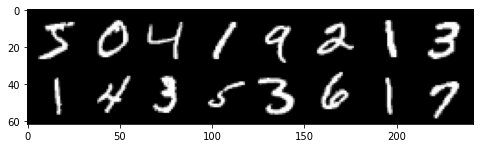

In [6]:
plot_image(mnist)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


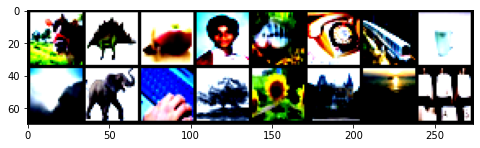

In [7]:
plot_image(cifar)

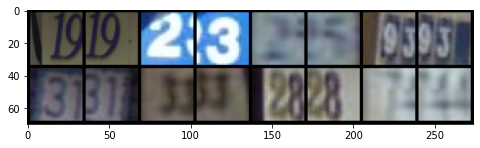

In [8]:
plot_image(svhn)

# Model Architecture

In [9]:
class Bottleneck(nn.Module):
  '''
  This is a bottleneck layer for building ResNet 50 with sigmoid activations
  '''
  def __init__(self, in_channels, out_channels):
    super(Bottleneck, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1), stride=(1, 1), bias=False)
    self.bn1 =  nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    # self.conv3 = nn.Conv2d(out_channels, out_channels*4, kernel_size=(1, 1), stride=(1, 1), bias=False)
    # self.bn3 = nn.BatchNorm2d(out_channels*4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    nn.init.uniform_(self.conv1.weight, a=-0.5 , b=0.5)
    nn.init.uniform_(self.conv2.weight, a=-0.5 , b=0.5)
    # nn.init.uniform_(self.conv1.bias, a=-0.5 , b=0.5)
    # nn.init.uniform_(self.conv2.bias, a=-0.5 , b=0.5)
    # nn.init.uniform_(self.mean.weight, mean=0.0, std=0.01)



    self.shortcut_projection = None
    if in_channels != out_channels*4:
      self.shortcut_projection = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
          nn.BatchNorm2d(out_channels)   
      )

  def forward(self, x):
    output = torch.sigmoid(self.bn1(self.conv1(x)))
    output = self.bn2(self.conv2(output))
    # output = self.bn3(self.conv3(output))
    # if input and output are not the same shape, perform a projection before adding the input to the output
    if self.shortcut_projection:
      output += self.shortcut_projection(x)
    else:
      output += x
    return torch.sigmoid(output)

In [10]:
class ResNet18(nn.Module):
  '''
  Resnet50 with sigmoid activations and strides of 1
  '''
  def __init__(self, in_channels, out_channels):
    super(ResNet18, self).__init__()
    self.blocks = [2, 2, 2, 2]
    self.block_input = 64
    self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=(7, 7), stride=1, padding=(3, 3), bias=False)
    self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.layer1 = self._build_layer(self.blocks[0], 64)
    self.layer2 = self._build_layer(self.blocks[1], 128)
    self.layer3 = self._build_layer(self.blocks[2], 256)
    self.layer4 = self._build_layer(self.blocks[3], 512)
    self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    self.linear = nn.Linear(512, out_channels)

    nn.init.uniform_(self.conv1.weight, a=-0.5 , b=0.5)
    # nn.init.uniform_(self.conv1.bias, a=-0.5 , b=0.5)
    nn.init.uniform_(self.linear.weight, a=-0.5 , b=0.5)
    nn.init.uniform_(self.linear.bias, a=-0.5 , b=0.5)

  def _build_layer(self, blocks, block_output):
    layers = []
    for block in range(blocks):
      layers.append(Bottleneck(self.block_input, block_output))
      self.block_input = block_output * 1
    return nn.Sequential(*layers)

  def forward(self, x):
    x = torch.sigmoid(self.bn1(self.conv1(x)))
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.avgpool(x)
    x = self.linear(x.view(-1, 512))
    return x

In [20]:
class LeNet(nn.Module):
  def __init__(self, in_channels, out_channels, img_size):
      super(LeNet, self).__init__()
      self.conv = nn.Sequential(
          nn.Conv2d(in_channels, 12, kernel_size=5, padding=5//2, stride=2),
          nn.Sigmoid(),
          nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
          nn.Sigmoid(),
          nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
          nn.Sigmoid(),
      )
      x_dummy = torch.randn(1, in_channels, img_size, img_size).to(device)
      # print((self.body(x_dummy)).shape)
      out_size = torch.prod( torch.tensor((self.conv(x_dummy)).shape))
      # print(out_size)
      self.linear = nn.Sequential(
          nn.Linear(out_size, out_channels)
      )
      for layer in self.conv:
        if type(layer) != nn.Sigmoid:
          nn.init.uniform_(layer.weight, a=-0.5 , b=0.5)
          nn.init.uniform_(layer.bias, a=-0.5 , b=0.5)
      for layer in self.linear:
        nn.init.uniform_(layer.weight, a=-0.5 , b=0.5)
        nn.init.uniform_(layer.bias, a=-0.5 , b=0.5)

  def forward(self, x):
    x = self.conv(x)
    x = x.view(x.shape[0], -1)
    x = self.linear(x)
    return x

# Training functions

In [63]:
def train(model, target_grad, dummy_input, dummy_target, optimizer, epochs, plot=True, img=None):
  # move the model to the device
  model.train()
  # training loop
  iterations = []
  stack_list = []
  for epoch in range(epochs):
    def closure():
      optimizer.zero_grad()
      # generate dummy data for generating dummy gradients
      doutput = model(dummy_input.unsqueeze(dim=0).to(device))
      target = F.softmax(dummy_target, dim=-1).to(device)
      loss = cross_entropy_onehot
      loss = loss(doutput, target)
      # print(loss)
      dummy_grad = torch.autograd.grad(loss, model.parameters(), create_graph=True) # dummy gradient
      # compute the MSE between the true and dummy grad
      square_loss = 0
      for dg, tg in zip(dummy_grad, target_grad):
        square_loss += ((dg - tg).pow(2).sum())
      square_loss.backward()
      return square_loss
    optimizer.step(closure)
    if plot:
      if (epoch) % 50 == 0:
        stack_list.append(torch.clone(dummy_input))
        stack = torch.stack(list(reversed(list(reversed(stack_list)) + [img])))
        print(len(stack))
        print(f"Epoch {epoch+1}, loss: {closure()}")
        iterations.append(epoch)
        # if dummy_input.cpu().shape[0] == 1:
        grid = make_grid(stack, nrow=len(stack), )
        plt.imshow(grid.cpu().detach().permute(1, 2, 0))
        # print(dummy_input.min())
        # else:
          # plt.imshow(dummy_input.cpu().detach().permute(1, 2, 0))
          # print(dummy_input)
        plt.show()

In [46]:
def onehot(label, classes):
  onehot = torch.zeros(1, classes, device=device)
  onehot.scatter_(1, torch.tensor([[label]]).to(device), 1)
  return onehot

In [47]:
def cross_entropy_onehot(pred, target):
  return (- target * F.log_softmax(pred, dim=-1)).sum().to(device)

#Experiment MNIST

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
Epoch 1, loss: 14.04167366027832


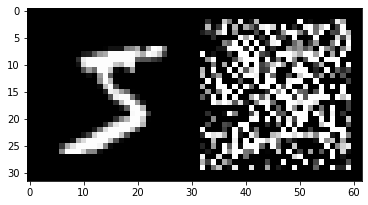

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
Epoch 51, loss: 1.579814501440069e-08


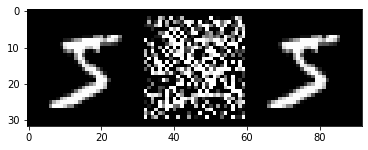

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
Epoch 101, loss: 1.579814501440069e-08


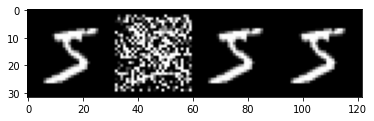

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5
Epoch 151, loss: 1.579814501440069e-08


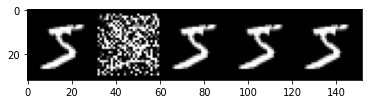

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6
Epoch 201, loss: 1.579814501440069e-08


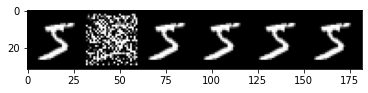

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7
Epoch 251, loss: 1.579814501440069e-08


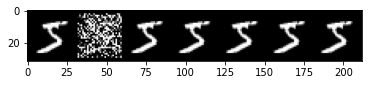

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8
Epoch 301, loss: 1.579814501440069e-08


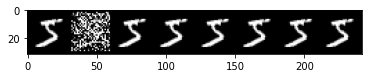

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9
Epoch 351, loss: 1.579814501440069e-08


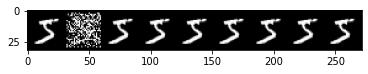

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10
Epoch 401, loss: 1.579814501440069e-08


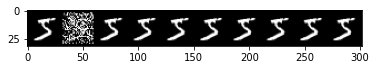

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11
Epoch 451, loss: 1.579814501440069e-08


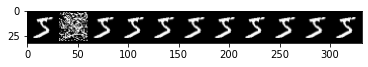

In [64]:
model = LeNet(1, 10, 28).to(device)
img_shape = next(iter(mnist))[0].shape

img, label = next(iter(mnist))
label_onehot = onehot(label, 10)
# print(img.shape)
# print("here")
output = model(img.unsqueeze(dim=0).to(device))
loss = cross_entropy_onehot
loss = loss(output, label_onehot)
# print(loss)
target_grad =  [g.detach() for g in torch.autograd.grad(loss, model.parameters())]

dummy_input = torch.randn(img_shape).requires_grad_(True)
dummy_output = torch.randn(len(mnist.classes)).requires_grad_(True)

optimizer = opt.LBFGS([dummy_input, dummy_output], lr=1.)
train(model, target_grad, dummy_input, dummy_output, optimizer, epoch_image_classification, img=img)

# Experiments CIFA 100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
Epoch 1, loss: 176.9286651611328


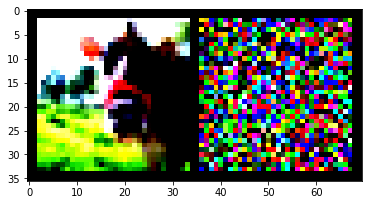

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
Epoch 51, loss: 0.052263982594013214


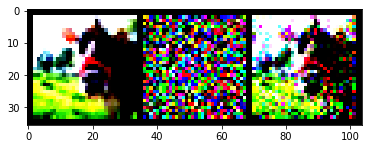

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
Epoch 101, loss: 0.0037825866602361202


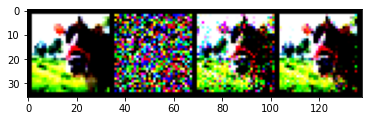

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5
Epoch 151, loss: 0.0005793195450678468


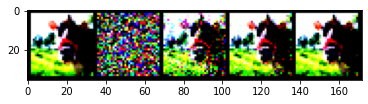

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6
Epoch 201, loss: 0.00012351435725577176


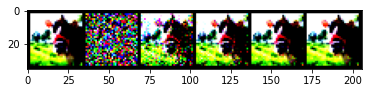

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7
Epoch 251, loss: 4.668728797696531e-05


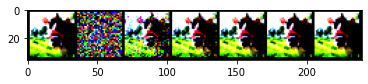

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8
Epoch 301, loss: 2.2115633328212425e-05


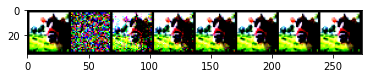

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9
Epoch 351, loss: 1.159226394520374e-05


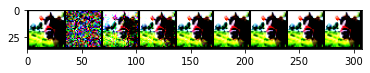

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10
Epoch 401, loss: 7.23876792108058e-06


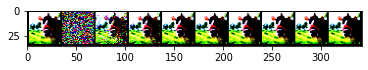

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11
Epoch 451, loss: 5.701657755707856e-06


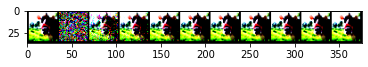

In [65]:
model = LeNet(3, 100, 32).to(device)
img_shape = next(iter(cifar))[0].shape

img, label = next(iter(cifar))
label_onehot = onehot(label, len(cifar.classes))
# print(img.shape)
# print("here")
output = model(img.unsqueeze(dim=0).to(device))
loss = cross_entropy_onehot
loss = loss(output, label_onehot)
# print(loss)
target_grad =  [g.detach() for g in torch.autograd.grad(loss, model.parameters())]

dummy_input = torch.randn(img_shape).requires_grad_(True)
dummy_output = torch.randn(len(cifar.classes)).requires_grad_(True)

optimizer = opt.LBFGS([dummy_input, dummy_output], lr=1.)
train(model, target_grad, dummy_input, dummy_output, optimizer, epoch_image_classification, img=img)

# Experiments SVHN

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
Epoch 1, loss: 70.26087188720703


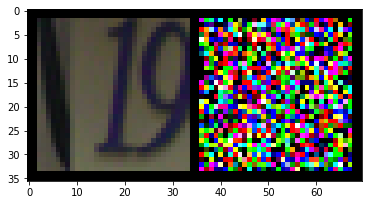

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
Epoch 51, loss: 0.0006745604914613068


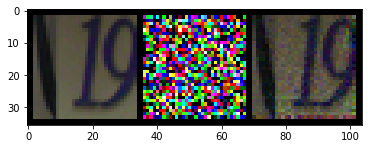

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
Epoch 101, loss: 9.03338150237687e-06


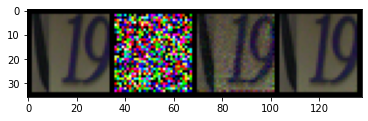

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5
Epoch 151, loss: 4.943869498674758e-06


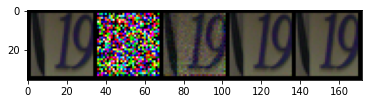

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6
Epoch 201, loss: 4.209829967294354e-06


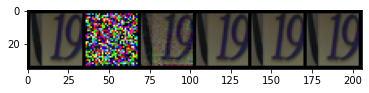

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7
Epoch 251, loss: 3.998572083219187e-06


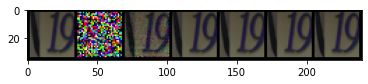

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8
Epoch 301, loss: 3.998572083219187e-06


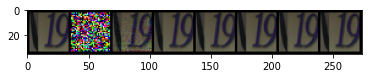

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9
Epoch 351, loss: 3.998572083219187e-06


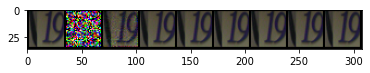

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10
Epoch 401, loss: 3.998572083219187e-06


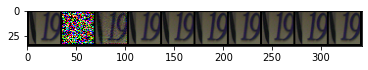

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11
Epoch 451, loss: 3.998572083219187e-06


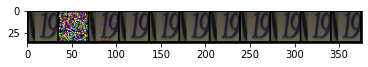

In [66]:
model = LeNet(3, 10, 32).to(device)
img_shape = next(iter(svhn))[0].shape

img, label = next(iter(svhn))
label_onehot = onehot(label,10)
# print(img.shape)
# print("here")
output = model(img.unsqueeze(dim=0).to(device))
loss = cross_entropy_onehot
loss = loss(output, label_onehot)
target_grad =  [g.detach() for g in torch.autograd.grad(loss, model.parameters())]

dummy_input = torch.randn(img_shape).requires_grad_(True)
dummy_output = torch.randn(10,).requires_grad_(True)

optimizer = opt.LBFGS([dummy_input, dummy_output], lr=1.)
train(model, target_grad, dummy_input, dummy_output, optimizer, epoch_image_classification, img=img)